# **Malaria Detection**

## Problem Definition</b>
 Malaria is a contagious disease caused by Plasmodium parasites that are transmitted to humans
 through the bites of infected female Anopheles mosquitoes. The parasites enter the blood and begin
 damaging red blood cells (RBCs) that carry oxygen, which can result in respiratory distress and other
 complications. The lethal parasites can stay alive for more than a year in a person’s body without
 showing any symptoms. Therefore, late treatment can cause complications and could even be fatal.
 Almost 50% of the world’s population is in danger from malaria. There were more than 229 million
 malaria cases and 400,000 malaria-related deaths reported over the world in 2019. Children under 5
 years of age are the most vulnerable population group affected by malaria; in 2019 they accounted
 for 67% of all malaria deaths worldwide.

 Traditional diagnosis of malaria in the laboratory requires careful inspection by an experienced
 professional to discriminate between healthy and infected red blood cells. It is a tedious,
 time-consuming process, and the diagnostic accuracy (which heavily depends on human expertise)
 can be adversely impacted by inter-observer variability.
 
 An automated system can help with the early and accurate detection of malaria. Applications of
 automated classification techniques using Machine Learning (ML) and Artificial Intelligence (AI) have
 consistently shown higher accuracy than manual classification. It would therefore be highly beneficial
 to propose a method that performs malaria detection using Deep Learning Algorithms.


**The objectives:** 
 Build an efficient computer vision model to detect malaria. The model should identify whether the
 image of a red blood cell is that of one infected with malaria or not, and classify the same as
 parasitized or uninfected, respectively.<br>
 

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


### <b>Loading libraries</b>

In [1]:
import os
from PIL import Image
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout , LeakyReLU, BatchNormalization, RandomRotation, RandomFlip
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

### <b>Let us load the data</b>

In [2]:
# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile('cell_images.zip', 'r') as zip_ref:
    zip_ref.extractall()

The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [3]:
def load_images_from_directory(directory, target_size):
    images = []
    labels = []
    for folder_name in ['parasitized', 'uninfected']:
        folder_path = os.path.join(directory, folder_name)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            img = img.resize(target_size)
            images.append(np.array(img))
            if folder_name == 'parasitized':
                labels.append(1)
            else:
                labels.append(0)
    return images, labels


In [4]:
train_images, train_labels = load_images_from_directory(r'cell_images\train', target_size = (64, 64))
test_images, test_labels = load_images_from_directory(r'cell_images\test', target_size = (64, 64))

train_images, train_labels, test_images, test_labels = np.array(train_images), np.array(train_labels), np.array(test_images), np.array(test_labels)

### Check the shape of train and test images

In [5]:
print('Shape of the train Image data:', train_images.shape)
print('Shape of the test Image data:', test_images.shape)

Shape of the train Image data: (24958, 64, 64, 3)
Shape of the test Image data: (2600, 64, 64, 3)


### Check the shape of train and test labels

In [6]:
print('Shape of the train labels:', train_labels.shape)
print('Shape of the test labels:', test_labels.shape)

Shape of the train labels: (24958,)
Shape of the test labels: (2600,)


#### Observations and insights: 
The train and test data are split by 90:10 ratio


### <b>Check the minimum and maximum range of pixel values for train and test images

In [7]:
train_max_pixel_value = []

for img in train_images:
    train_max_pixel_value.append(np.max(img))

test_max_pixel_value = []

for img in test_images:
    test_max_pixel_value.append(np.max(img))

print('Maximum Pixel Value in train data :', max(train_max_pixel_value))
print('Maximum Pixel Value in test data :', max(test_max_pixel_value))

Maximum Pixel Value in train data : 255
Maximum Pixel Value in test data : 255


#### Observations and insights: 
The maximum pixel intensity is 255, thats the max intensity that any image can have. we can deduct that there are some black patches in the image. 



### Count the number of values in both uninfected and parasitized 

In [8]:
import pandas as pd

pd.Series(train_labels).value_counts()

1    12582
0    12376
Name: count, dtype: int64

### Normalize the images

In [9]:
train_images_normalized = (train_images/255.0).astype('float32')
test_images_normalized = (test_images/255.0).astype('float32')

### Plot to check if the data is balanced

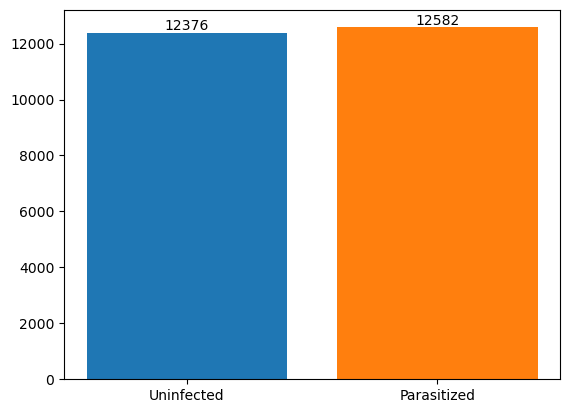

In [10]:
train_length = train_labels.size
train_parasitized = np.sum(train_labels)
train_uninfected = train_length - train_parasitized

train_plot = plt.bar(x = 'Uninfected', height = train_uninfected)
plt.bar_label(train_plot)
train_plot = plt.bar(x = 'Parasitized', height = train_parasitized)
plt.bar_label(train_plot)
plt.show()


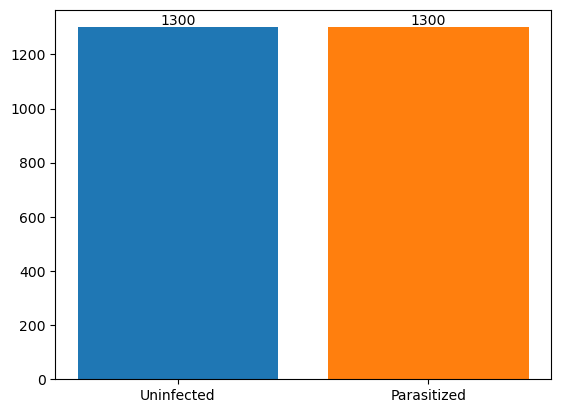

In [11]:
test_length = test_labels.size
test_parasitized = np.sum(test_labels)
test_uninfected = test_labels.size - test_parasitized

test_plot = plt.bar(x = 'Uninfected', height = test_uninfected)
plt.bar_label(test_plot)
test_plot = plt.bar(x = 'Parasitized', height = test_parasitized)
plt.bar_label(test_plot)
plt.show()

#### Observations and insights: 
The Data is Balance across the train and test Dataset

### <b>Data Exploration</b>
Let's visualize the images from the train data

### Visualize the images

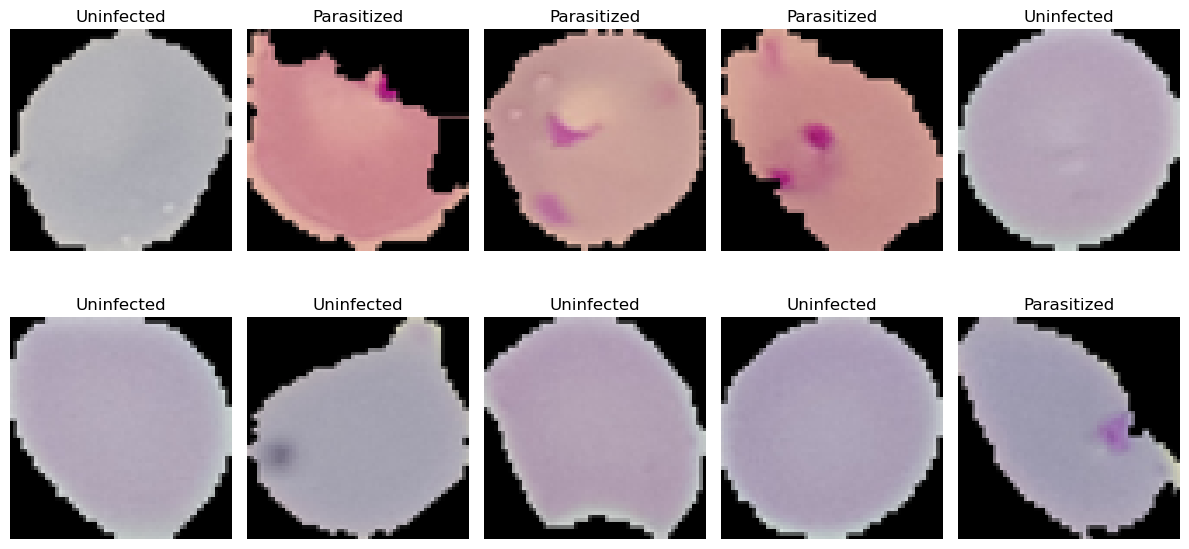

In [12]:
import matplotlib.pyplot as plt

np.random.seed(500)

random_ten_train_indexes = np.random.randint(0, train_images_normalized.shape[0], 10)
random_ten_test_indexes = np.random.randint(0, test_images_normalized.shape[0], 10)

_, axs = plt.subplots(2, 5, figsize = (12, 8))

axs = axs.flatten()
for i, ax in zip(random_ten_train_indexes, axs):
    ax.imshow(train_images_normalized[i])
    if train_labels[i] == 0:   
        ax.set_title('Uninfected')
    else:
        ax.set_title('Parasitized')
        ax.margins(0.2)
    ax.axis('off')
    plt.tight_layout()

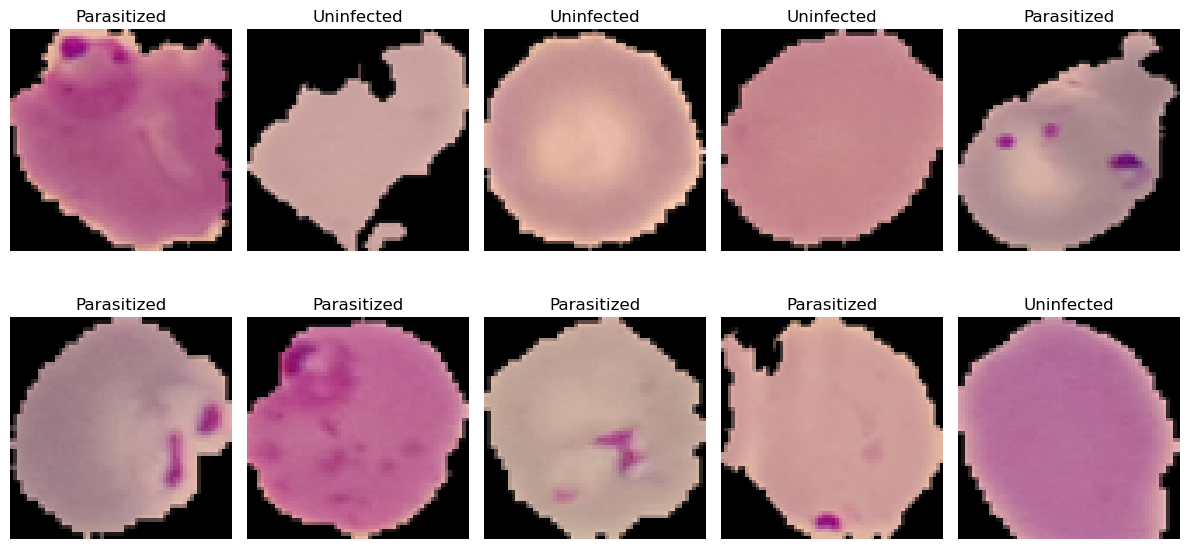

In [13]:
_, axs = plt.subplots(2, 5, figsize = (12, 8))

axs = axs.flatten()
for i, ax in zip(random_ten_test_indexes, axs):
    ax.imshow(test_images_normalized[i])
    if test_labels[i] == 0:   
        ax.set_title('Uninfected')
    else:
        ax.set_title('Parasitized')
        ax.margins(0.2)
    ax.axis('off')
    plt.tight_layout()

 #### Observations and insights:
The Parasitized images have a pink intense spots in the cells, Where as the uninfected ones does not have intense spots.

### <b>Converting RGB to HSV of Images using OpenCV

### Converting the train data

In [14]:
train_gfx=[]   # to hold the HSV image array
for i, j in enumerate(train_images):
    a = cv2.cvtColor(train_images[i], cv2.COLOR_BGR2HSV)
    train_gfx.append(a)

train_gfx = np.array(train_gfx)

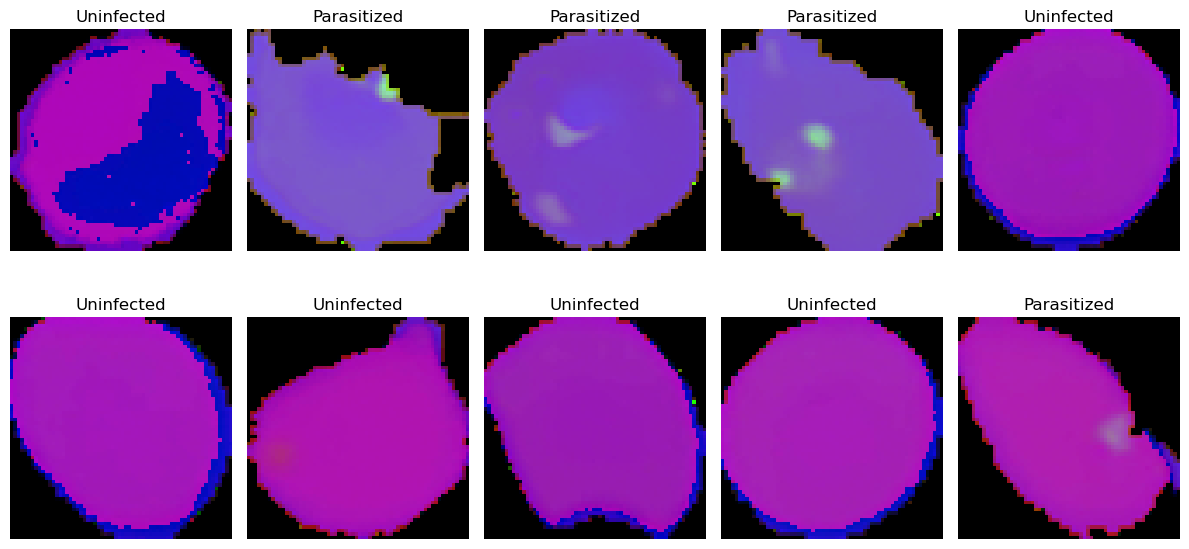

In [15]:
_, axs = plt.subplots(2, 5, figsize = (12, 8))

axs = axs.flatten()
for i, ax in zip(random_ten_train_indexes, axs):
    ax.imshow(train_gfx[i])
    if train_labels[i] == 0:   
        ax.set_title('Uninfected')
    else:
        ax.set_title('Parasitized')
    ax.axis('off')
    plt.tight_layout()

### Converting the test data

In [16]:
test_gfx=[]   # to hold the HSV image array

for i, j in enumerate(test_images):
  a = cv2.cvtColor(test_images[i], cv2.COLOR_BGR2HSV) 
  test_gfx.append(a)

test_gfx = np.array(test_gfx)

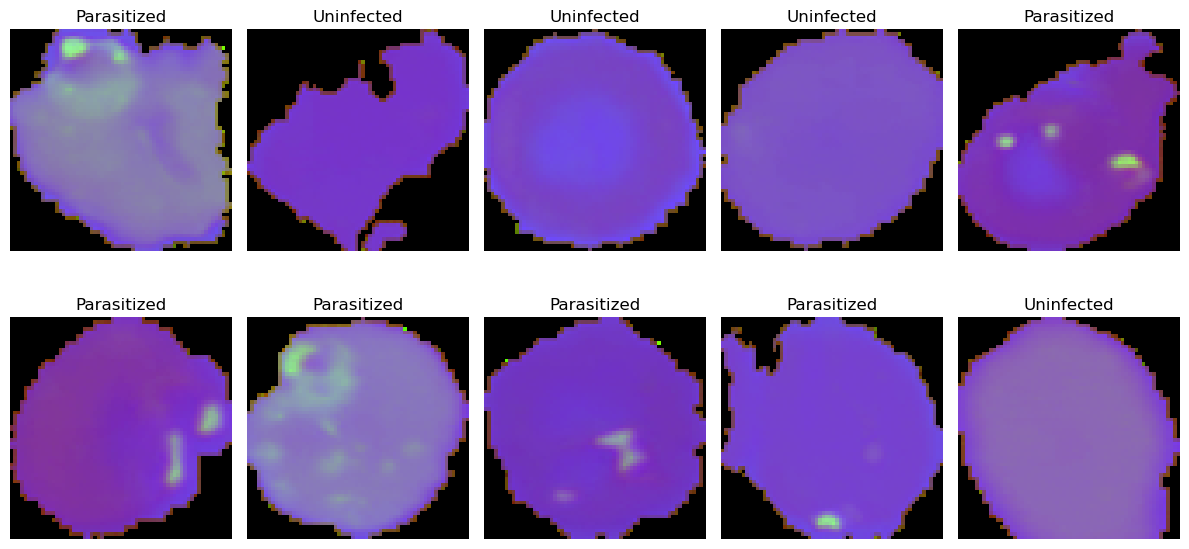

In [17]:
_, axs = plt.subplots(2, 5, figsize = (12, 8))

axs = axs.flatten()
for i, ax in zip(random_ten_test_indexes, axs):
    ax.imshow(test_gfx[i])
    if test_labels[i] == 0:   
        ax.set_title('Uninfected')
    else:
        ax.set_title('Parasitized')
    ax.axis('off')
    plt.tight_layout()

#### Observations and insights: 
We can see that athere are some intense spots in the Parasitized images similar to RGB Images. Although it would not add any additional information for the model to inprove the accuracy, but would make it obvious.

### Processing Images using Gaussian Blurring

### Gaussian Blurring on train data

In [18]:
train_gaussian=[]   # to hold the blurred image array
for i, j in enumerate(train_images):
  a = cv2.GaussianBlur(train_images_normalized[i], (3,3), 0) 
  train_gaussian.append(a)

train_gaussian = np.array(train_gaussian)

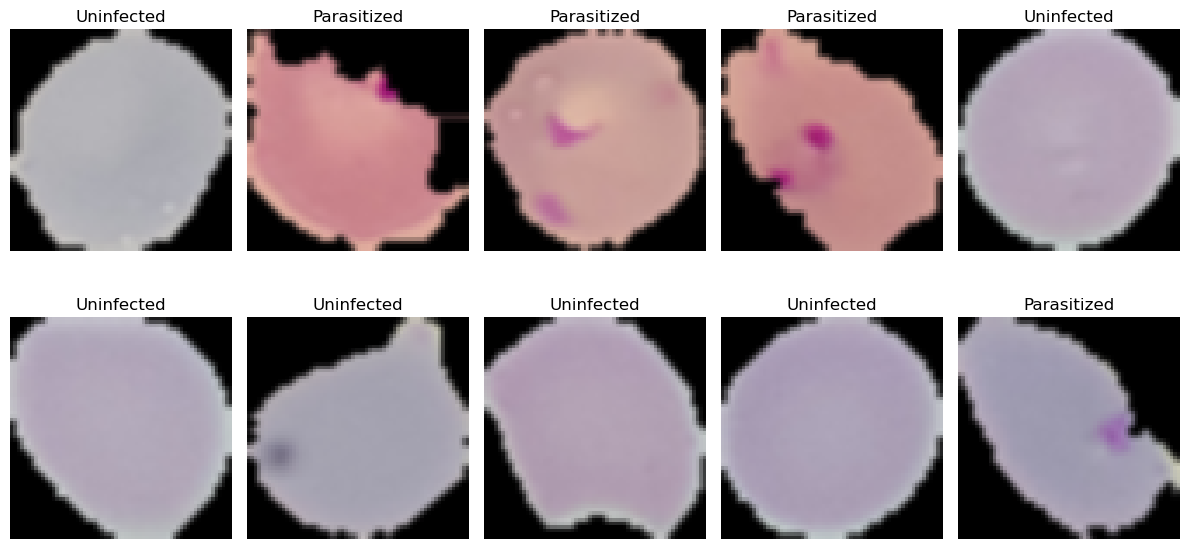

In [19]:
_, axs = plt.subplots(2, 5, figsize = (12, 8))

axs = axs.flatten()
for i, ax in zip(random_ten_train_indexes, axs):
    ax.imshow(train_gaussian[i])
    if train_labels[i] == 0:   
        ax.set_title('Uninfected')
    else:
        ax.set_title('Parasitized')
    ax.axis('off')
    plt.tight_layout()

### Gaussian Blurring on test data

In [20]:
test_gaussian=[]   # to hold the blurred image array

for i, j in enumerate(test_images):
  a = cv2.GaussianBlur(test_images_normalized[i], (3,3), 0)
  test_gaussian.append(a)

test_gaussian = np.array(test_gaussian)

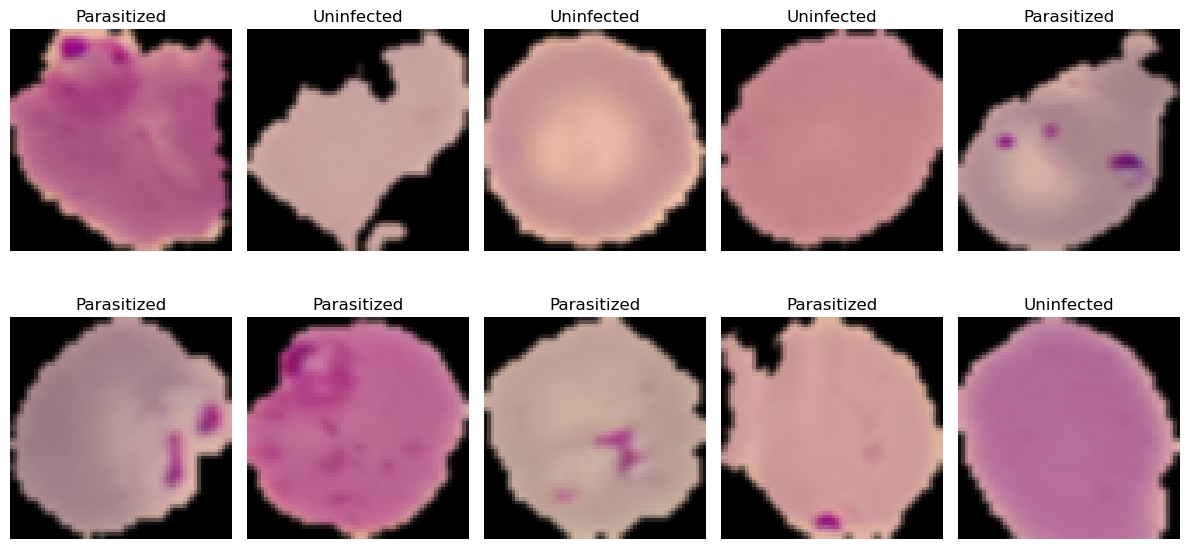

In [21]:
_, axs = plt.subplots(2, 5, figsize = (12, 8))

axs = axs.flatten()
for i, ax in zip(random_ten_test_indexes, axs):
    ax.imshow(test_gaussian[i])
    if test_labels[i] == 0:   
        ax.set_title('Uninfected')
    else:
        ax.set_title('Parasitized')
    ax.axis('off')
    plt.tight_layout()

In [22]:
del train_gaussian
del test_gaussian

#### Observations and insights: 

## **Model Building**

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

#### One Hot Encoding the train and test labels

In [23]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

### Building the model

In [24]:
def model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
    model.add(MaxPooling2D(pool_size = 2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

### Compiling the model

In [25]:
model1 = model()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

<b> Using Callbacks 

In [26]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3)]

<b> Fit and train our Model

In [27]:
history1 = model1.fit(train_images_normalized, train_labels, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 10s 7ms/step - loss: 0.4607 - accuracy: 0.7777 - val_loss: 0.4264 - val_accuracy: 0.9679
Epoch 2/20
624/624 [==============================] - 4s 7ms/step - loss: 0.1580 - accuracy: 0.9460 - val_loss: 0.1408 - val_accuracy: 0.9738
Epoch 3/20
624/624 [==============================] - 4s 6ms/step - loss: 0.0978 - accuracy: 0.9700 - val_loss: 0.1418 - val_accuracy: 0.9782
Epoch 4/20
624/624 [==============================] - 4s 7ms/step - loss: 0.0819 - accuracy: 0.9736 - val_loss: 0.1217 - val_accuracy: 0.9840
Epoch 5/20
624/624 [==============================] - 4s 6ms/step - loss: 0.0723 - accuracy: 0.9770 - val_loss: 0.1077 - val_accuracy: 0.9826
Epoch 6/20
624/624 [==============================] - 4s 7ms/step - loss: 0.0681 - accuracy: 0.9785 - val_loss: 0.1347 - val_accuracy: 0.9760
Epoch 7/20
624/624 [==============================] - 4s 6ms/step - loss: 0.0684 - accuracy: 0.9788 - val_loss: 0.1193 - val_accuracy: 0.9766
Epoch

### Evaluating the model on test data

In [28]:
accuracy = model1.evaluate(test_images_normalized, test_labels, verbose = 1)
results = {}
results['Basic CNN'] = accuracy[1]

print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 1s 5ms/step - loss: 0.0707 - accuracy: 0.9835

 Test_Accuracy:- 0.9834615588188171


<b> Plotting the confusion matrix

82/82 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1300
           1       0.98      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



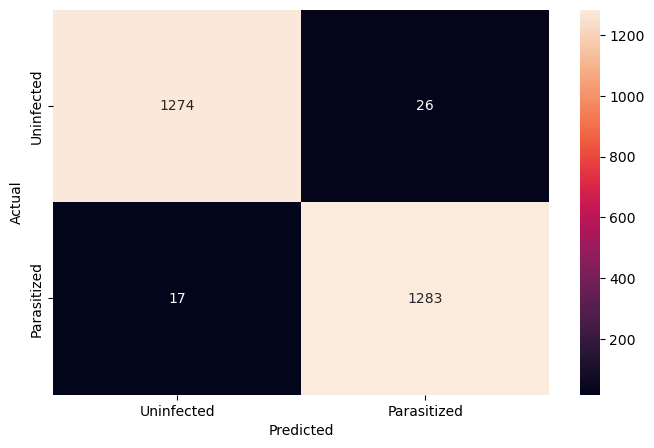

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = model1.predict(test_images_normalized)
pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)
# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plotting the train and validation curves

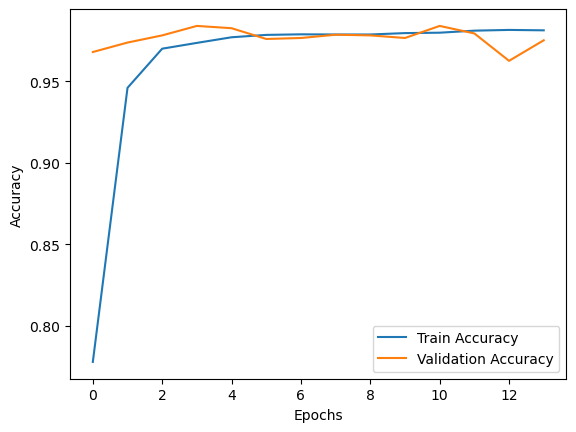

In [30]:
plt.plot(history1.history['accuracy'], label = 'Train Accuracy')
plt.plot(history1.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Here the Validation accuracy is more than the train accuracy. So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

<b> Model 2
<b> Trying to improve the performance of our model by adding new convolution layers, Batch Normalization, and LeakyReLU activation 


In [31]:
"""
The depth and width of the CNN is determined by tuner model below

def build_model(hp):  # random search passes this hyperparameter() object 
    model = Sequential()

    model.add(Conv2D(hp.Int('input_units',
                                min_value=32,
                                max_value=256,
                                step=32), (2, 2), padding = 'same', input_shape=(64, 64, 3)))

    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    for i in range(hp.Int('n_layers', 1, 8)):  # adding variation of layers.
        model.add(Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), padding = 'same', (2, 2)))
        model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    for i in range(hp.Int('n_connections', 1, 4)):
        model.add(Dense(hp.Choice(f'n_nodes',
                                  values = [64, 128, 512, 1024]), activation = 'relu'))
        
    model.add(Dense(2, activation = 'softmax'))

    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

-- random search with objective as validation accuracy
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    overwrite=True,
    max_trials=10,  # totAL model variations to test
    executions_per_trial=2)  # trails for each variation 

tuner.search(x=train_images_normalized,
             y=train_labels,
             epochs=5,
             batch_size=32,
             validation_data = (test_images_normalized, test_labels))

print(tuner.get_best_hyperparameters()[0].values)

---------------------------------------------------------

output: {'input_units': 160, 'n_layers': 5, 'conv_0_units': 224, 'n_connections': 3, 'n_nodes': 1024, 'conv_1_units': 224, 
'conv_2_units': 96, 'conv_3_units': 160, 'conv_4_units': 96, 'conv_5_units': 224, 'conv_6_units': 96, 'conv_7_units': 32}

"""

def model2():
    model = Sequential()
    
    model.add(Conv2D(160, padding = 'same', kernel_size = (2, 2), input_shape=(64, 64, 3)))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(224, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(224, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(96, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(160, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(96, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(224, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(96, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024, activation = 'relu')) 
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dense(2, activation = 'softmax'))

    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model


### Building the Model

In [32]:
model2 = model2()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 160)       2080      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 160)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 160)      640       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 160)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 224)       143584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 224)      

<b> Using Callbacks

In [33]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3)]

<b>Fit and Train the model

In [34]:
history2 = model2.fit(train_images_normalized, train_labels, 
                      batch_size = 32, callbacks = callbacks, 
                      validation_split = 0.2, epochs = 10, verbose = 1)

Epoch 1/10
624/624 [==============================] - 46s 71ms/step - loss: 0.2820 - accuracy: 0.8837 - val_loss: 0.0408 - val_accuracy: 0.9896
Epoch 2/10
624/624 [==============================] - 44s 70ms/step - loss: 0.0796 - accuracy: 0.9740 - val_loss: 0.1203 - val_accuracy: 0.9637
Epoch 3/10
624/624 [==============================] - 41s 66ms/step - loss: 0.0879 - accuracy: 0.9743 - val_loss: 0.0804 - val_accuracy: 0.9683
Epoch 4/10
624/624 [==============================] - 42s 67ms/step - loss: 0.0645 - accuracy: 0.9799 - val_loss: 0.1962 - val_accuracy: 0.9425


### Evaluating the model

In [35]:
accuracy = model2.evaluate(test_images_normalized, test_labels, verbose = 1)
results['CNN with LeakyReLU & Batch Normalizer'] = accuracy[1]
print('--'*50)
print('Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 2s 25ms/step - loss: 0.1099 - accuracy: 0.9677
----------------------------------------------------------------------------------------------------
Test_Accuracy:- 0.9676923155784607


<b> Plotting the confusion matrix

82/82 [==============================] - 2s 23ms/step
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1300
           1       0.94      1.00      0.97      1300

    accuracy                           0.97      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.97      0.97      0.97      2600



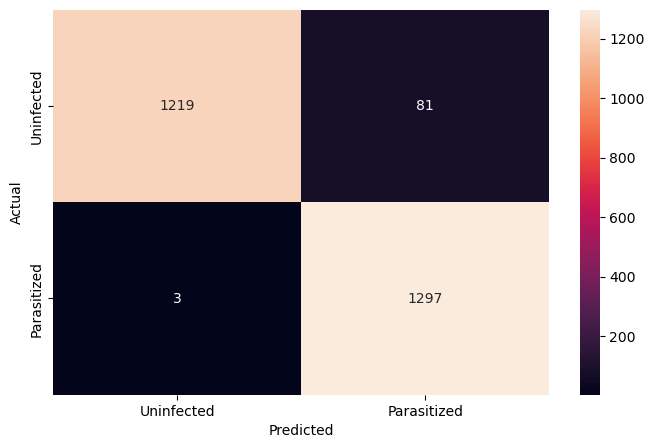

In [36]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = model2.predict(test_images_normalized)
pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)
# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Plotting the train and the validation curves

Text(0, 0.5, 'Accuracy')

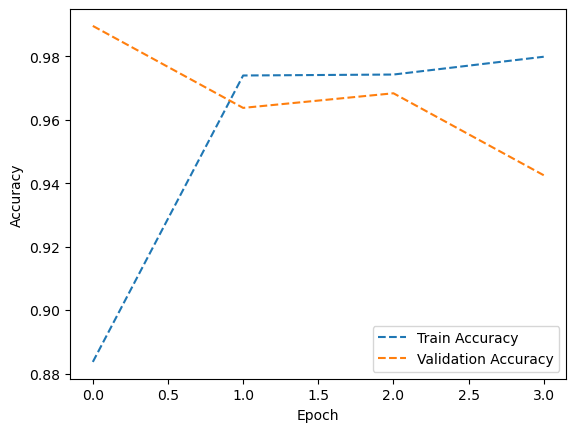

In [37]:
plt.plot(history2.history['accuracy'], ls = '--', label = 'Train Accuracy')
plt.plot(history2.history['val_accuracy'], ls = '--', label = 'Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [38]:
backend.clear_session()

### Model 3 with Data Augmentation

### Use image data generator

In [39]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images_normalized, train_labels, test_size = 0.2, random_state = 42)

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(rotation_range=90,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip = True)

test_datagen  = ImageDataGenerator(rotation_range=90,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip = True)

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = X_train.shape[0], seed = 42, shuffle = True)

# Flowing validation images using val_datagen generator
test_generator =  test_datagen.flow(x = X_val, y = y_val, batch_size = X_val.shape[0], seed = 42, shuffle = True)


#### Visualizing Augmented images

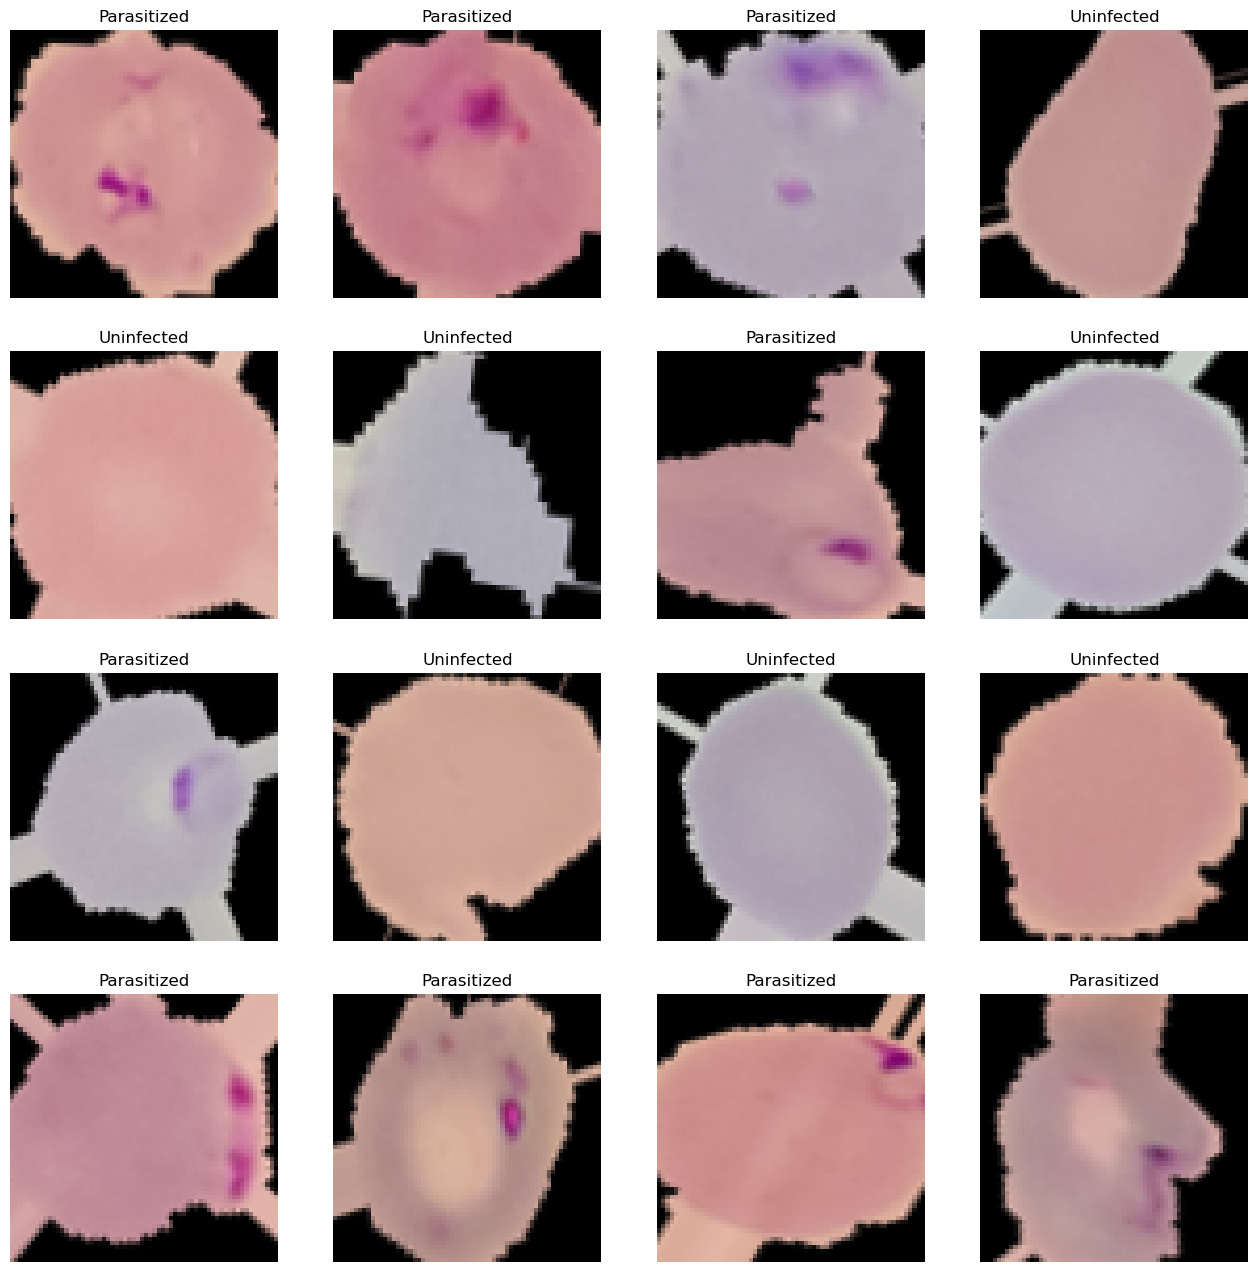

In [40]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label[1] == 1: 
        ax.set_title('Parasitized')
    else:
        ax.set_title('Uninfected')
    ax.axis('off')

#### Observations and insights: 
We can clearly see the image variations. but hte distinctive feature for the Parasitized and uninfected images is visible.

### Building the Model

In [41]:
def model_augmented():  # random search passes this hyperparameter() object 

    model = Sequential()
    
    model.add(Conv2D(160, padding = 'same', kernel_size = (2, 2), input_shape=(64, 64, 3)))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(224, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(224, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(96, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(160, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(96, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(224, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(96, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024, activation = 'relu')) 
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dense(2, activation = 'softmax'))

    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [42]:
model_augmented = model_augmented()
model_augmented.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 160)       2080      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 160)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 160)      640       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 160)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 224)       143584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 224)       0

<b>Using Callbacks

In [43]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3)]

<b> Fit and Train the model

In [44]:
train_img_gen, train_labels_gen = next(train_generator)
test_img_gen, test_labels_gen = next(test_generator)

In [45]:
history_aug = model_augmented.fit(x=train_img_gen, y=train_labels_gen,
             epochs=10,
             batch_size=32,
             validation_data = (test_img_gen, test_labels_gen))

Epoch 1/10
624/624 [==============================] - 44s 68ms/step - loss: 0.6646 - accuracy: 0.6484 - val_loss: 1.4609 - val_accuracy: 0.6280
Epoch 2/10
624/624 [==============================] - 43s 69ms/step - loss: 0.1515 - accuracy: 0.9540 - val_loss: 0.1048 - val_accuracy: 0.9694
Epoch 3/10
624/624 [==============================] - 41s 65ms/step - loss: 0.0921 - accuracy: 0.9709 - val_loss: 0.0798 - val_accuracy: 0.9738
Epoch 4/10
624/624 [==============================] - 40s 64ms/step - loss: 0.0821 - accuracy: 0.9729 - val_loss: 0.0909 - val_accuracy: 0.9744
Epoch 5/10
624/624 [==============================] - 41s 66ms/step - loss: 0.0842 - accuracy: 0.9749 - val_loss: 0.0978 - val_accuracy: 0.9583
Epoch 6/10
624/624 [==============================] - 43s 69ms/step - loss: 0.0764 - accuracy: 0.9769 - val_loss: 0.0952 - val_accuracy: 0.9661
Epoch 7/10
624/624 [==============================] - 43s 69ms/step - loss: 0.0728 - accuracy: 0.9776 - val_loss: 0.0897 - val_accuracy:

### Evaluating the model

In [46]:
accuracy = model_augmented.evaluate(test_images_normalized, test_labels, verbose = 1)
results['Image Augmentation'] = accuracy[1]

print('--'*50)
print('Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 2s 23ms/step - loss: 0.1490 - accuracy: 0.9723
----------------------------------------------------------------------------------------------------
Test_Accuracy:- 0.9723076820373535


<b>Plot the train and validation accuracy

Text(0, 0.5, 'Accuracy')

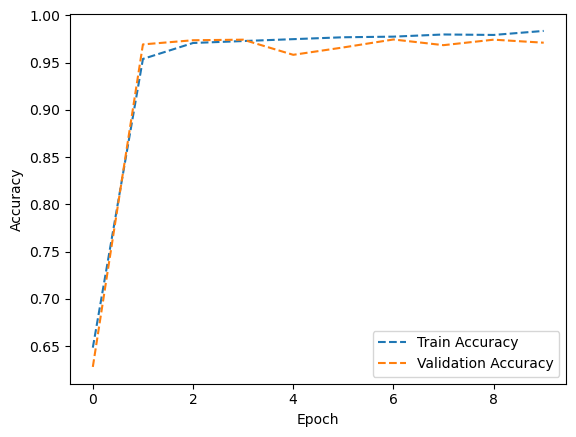

In [47]:
plt.plot(history_aug.history['accuracy'], ls = '--', label = 'Train Accuracy')
plt.plot(history_aug.history['val_accuracy'], ls = '--', label = 'Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

<B>Plotting the classification report and confusion matrix

82/82 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

           0       0.97      0.18      0.30      1300
           1       0.55      1.00      0.71      1300

    accuracy                           0.59      2600
   macro avg       0.76      0.59      0.50      2600
weighted avg       0.76      0.59      0.50      2600



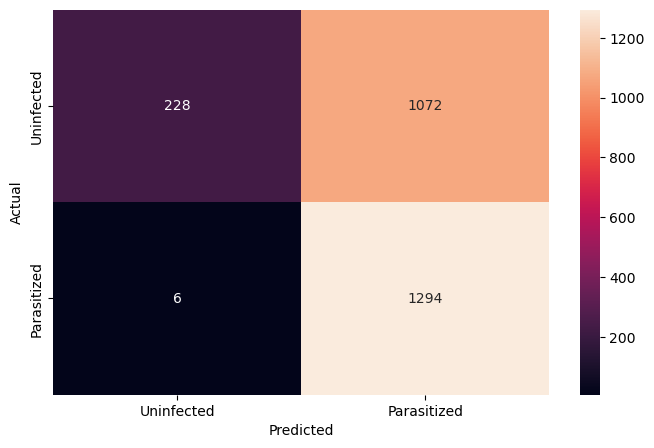

In [48]:
pred = model_augmented.predict(test_images)
pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)
# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [49]:
backend.clear_session()

del test_img_gen
del test_labels_gen
del train_img_gen 
del train_labels_gen

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [50]:
# Importing necessary libraries
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16

In [51]:
vgg_model = VGG16(weights = 'imagenet',
                       include_top = False,
                       input_shape = (64, 64, 3), pooling = 'max')

In [52]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [53]:
print('Number of Layers in VGG16:', len(vgg_model.layers))

Number of Layers in VGG16: 20


In [54]:
for layer in vgg_model.layers:
    layer.trainable = False # Fixing all the weights in layers to be not trainable

In [55]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [56]:
x = Flatten()(vgg_model.output)
x = Dense(256, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
x = BatchNormalization()(x)

pred = Dense(2, activation = 'softmax')(x)

# Initializing the model
model_4 = Model(vgg_model.input, pred)

### Compiling the model

In [57]:
model_4.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

<b> using callbacks

In [58]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3)]

<b>Fit and Train the model

In [59]:
history_4 = model_4.fit(
            train_images_normalized, 
            train_labels,
            epochs = 10,
            batch_size = 32,
            validation_split = 0.2,
            verbose = 1,
            callbacks = callbacks        
)

Epoch 1/10
624/624 [==============================] - 14s 20ms/step - loss: 0.2052 - accuracy: 0.9175 - val_loss: 0.3882 - val_accuracy: 0.8405
Epoch 2/10
624/624 [==============================] - 11s 18ms/step - loss: 0.1636 - accuracy: 0.9371 - val_loss: 0.1760 - val_accuracy: 0.9367
Epoch 3/10
624/624 [==============================] - 11s 18ms/step - loss: 0.1516 - accuracy: 0.9407 - val_loss: 1.0773 - val_accuracy: 0.5843
Epoch 4/10
624/624 [==============================] - 11s 18ms/step - loss: 0.1469 - accuracy: 0.9436 - val_loss: 0.2865 - val_accuracy: 0.8810
Epoch 5/10
624/624 [==============================] - 12s 19ms/step - loss: 0.1455 - accuracy: 0.9451 - val_loss: 0.0997 - val_accuracy: 0.9631
Epoch 6/10
624/624 [==============================] - 12s 19ms/step - loss: 0.1419 - accuracy: 0.9474 - val_loss: 0.2894 - val_accuracy: 0.8824
Epoch 7/10
624/624 [==============================] - 11s 18ms/step - loss: 0.1351 - accuracy: 0.9491 - val_loss: 0.8271 - val_accuracy:

<b>Plot the train and validation accuracy

Text(0, 0.5, 'Accuracy')

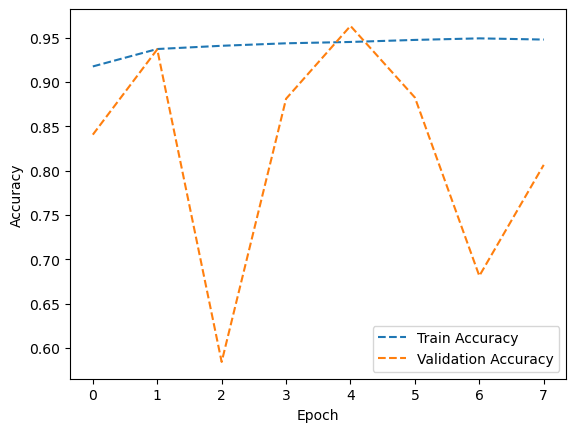

In [60]:
plt.plot(history_4.history['accuracy'], ls = '--', label = 'Train Accuracy')
plt.plot(history_4.history['val_accuracy'], ls = '--', label = 'Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

### Observations and insights: 
The VGG16 Model seems to have lower accuracy compared to previous models.

### Evaluating the model

In [61]:
accuracy = model_4.evaluate(test_images_normalized, test_labels)

results['VGG16 Transfer Learninng Model'] = accuracy[1]
print('--'*50)
print('Accuracy of the transfer learning model', accuracy[1])

82/82 [==============================] - 2s 18ms/step - loss: 0.3223 - accuracy: 0.8585
----------------------------------------------------------------------------------------------------
Accuracy of the transfer learning model 0.8584615588188171


<b>Plotting the classification report and confusion matrix

82/82 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      1300
           1       0.79      0.99      0.87      1300

    accuracy                           0.86      2600
   macro avg       0.88      0.86      0.86      2600
weighted avg       0.88      0.86      0.86      2600



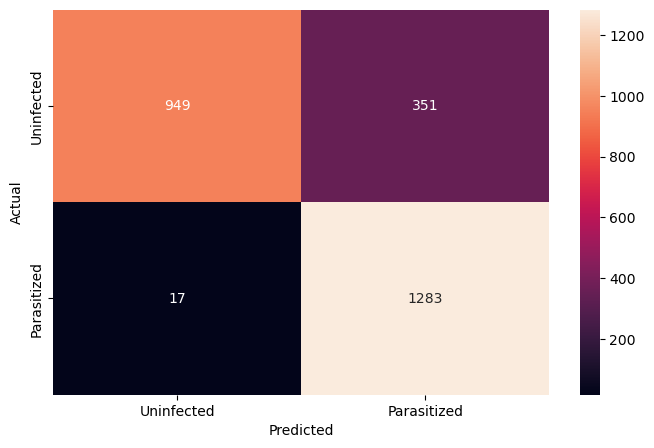

In [62]:
pred = model_4.predict(test_images_normalized)
pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)
# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [63]:
backend.clear_session()

del train_images
del test_images

### Build a Model on the HSV data


In [64]:
def model_hsv(): 

    model = Sequential()
    
    model.add(Conv2D(160, padding = 'same', kernel_size = (2, 2), input_shape=(64, 64, 3)))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(224, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(224, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(96, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(160, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(96, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(224, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(96, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024, activation = 'relu')) 
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dense(2, activation = 'softmax'))

    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

##### Build Model

In [65]:
model_hsv = model_hsv()
model_hsv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 160)       2080      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 160)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 160)      640       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 160)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 224)       143584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 224)       0

##### Callbacks

In [66]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3)]

In [67]:
history_hsv = model_hsv.fit(train_gfx, train_labels, batch_size = 32, epochs = 10, callbacks = [callbacks], validation_split = 0.2)

Epoch 1/10
624/624 [==============================] - 42s 66ms/step - loss: 0.2620 - accuracy: 0.9114 - val_loss: 0.0724 - val_accuracy: 0.9744
Epoch 2/10
624/624 [==============================] - 40s 65ms/step - loss: 0.0726 - accuracy: 0.9776 - val_loss: 0.1521 - val_accuracy: 0.9549
Epoch 3/10
624/624 [==============================] - 42s 67ms/step - loss: 0.0587 - accuracy: 0.9806 - val_loss: 0.2556 - val_accuracy: 0.9453
Epoch 4/10
624/624 [==============================] - 40s 65ms/step - loss: 0.0639 - accuracy: 0.9799 - val_loss: 0.1674 - val_accuracy: 0.9688


Text(0, 0.5, 'Accuracy')

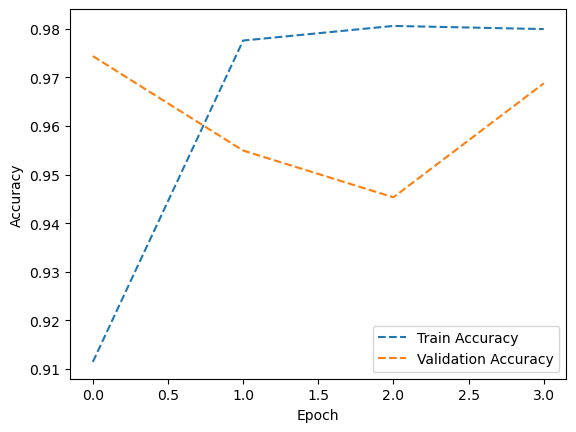

In [68]:
plt.plot(history_hsv.history['accuracy'], ls = '--', label = 'Train Accuracy')
plt.plot(history_hsv.history['val_accuracy'], ls = '--', label = 'Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [69]:
accuracy = model_hsv.evaluate(test_gfx, test_labels)

results['HSV Model'] = accuracy[1]
print('--'*50)
print('Accuracy of the transfer learning model', accuracy[1])

82/82 [==============================] - 2s 23ms/step - loss: 0.0778 - accuracy: 0.9850
----------------------------------------------------------------------------------------------------
Accuracy of the transfer learning model 0.9850000143051147


82/82 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1300
           1       0.98      0.99      0.99      1300

    accuracy                           0.98      2600
   macro avg       0.99      0.98      0.98      2600
weighted avg       0.99      0.98      0.98      2600



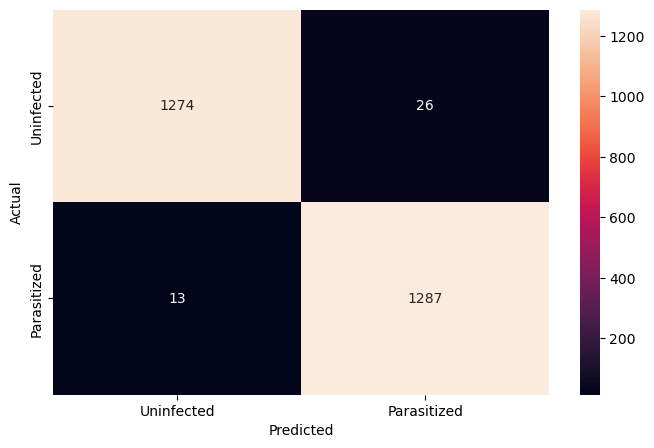

In [70]:
pred = model_hsv.predict(test_gfx)
pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)
# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Observations: 
The model seems to perform on par with other models. But the Fasle Positive are low compared to other models.

In [71]:
backend.clear_session()

### HSV with Image Augmentation

In [72]:
X_train, X_val, y_train, y_val = train_test_split(train_gfx, train_labels, test_size = 0.2, random_state = 42)

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(rotation_range=90,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip = True,
                                    rescale = 1./255)

test_datagen  = ImageDataGenerator(rotation_range=90,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip = True,
                                    rescale = 1./255)

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = X_train.shape[0], seed = 42, shuffle = True)

# Flowing validation images using val_datagen generator
test_generator =  test_datagen.flow(x = X_val, y = y_val, batch_size = X_val.shape[0], seed = 42, shuffle = True)

In [73]:
def model_hsv_image_gen(): 

    model = Sequential()
    
    model.add(Conv2D(160, padding = 'same', kernel_size = (2, 2), input_shape=(64, 64, 3)))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(224, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(224, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(96, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(160, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(96, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(224, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(96, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, padding = 'same', kernel_size=(2, 2)))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024, activation = 'relu')) 
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dense(2, activation = 'softmax'))

    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [74]:
model_hsv_image_gen = model_hsv_image_gen()
model_hsv_image_gen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 160)       2080      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 160)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 160)      640       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 160)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 224)       143584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 224)       0

In [75]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3)]

In [76]:
train_img_gen, train_labels_gen = next(train_generator)
test_img_gen, test_labels_gen = next(test_generator)

In [77]:
history_hsv_image_gen = model_hsv_image_gen.fit(train_img_gen, 
                                                train_labels_gen, 
                                                batch_size = 32, 
                                                epochs = 20, 
                                                callbacks = [callbacks], 
                                                validation_data = (test_img_gen, test_labels_gen))

Epoch 1/20
624/624 [==============================] - 42s 65ms/step - loss: 0.2866 - accuracy: 0.8970 - val_loss: 0.0972 - val_accuracy: 0.9698
Epoch 2/20
624/624 [==============================] - 39s 63ms/step - loss: 0.1011 - accuracy: 0.9703 - val_loss: 0.1269 - val_accuracy: 0.9631
Epoch 3/20
624/624 [==============================] - 39s 63ms/step - loss: 0.0903 - accuracy: 0.9720 - val_loss: 0.0926 - val_accuracy: 0.9639
Epoch 4/20
624/624 [==============================] - 40s 65ms/step - loss: 0.0766 - accuracy: 0.9769 - val_loss: 0.0911 - val_accuracy: 0.9764
Epoch 5/20
624/624 [==============================] - 41s 66ms/step - loss: 0.0793 - accuracy: 0.9770 - val_loss: 0.0856 - val_accuracy: 0.9732
Epoch 6/20
624/624 [==============================] - 42s 67ms/step - loss: 0.0710 - accuracy: 0.9785 - val_loss: 0.0887 - val_accuracy: 0.9669
Epoch 7/20
624/624 [==============================] - 45s 72ms/step - loss: 0.0656 - accuracy: 0.9797 - val_loss: 0.1223 - val_accuracy:

In [78]:
accuracy = model_hsv_image_gen.evaluate(test_gfx, test_labels)

results['HSV Model with Image augmentation'] = accuracy[1]
print('--'*50)
print('Accuracy of the transfer learning model', accuracy[1])

82/82 [==============================] - 2s 23ms/step - loss: 232.0609 - accuracy: 0.6769
----------------------------------------------------------------------------------------------------
Accuracy of the transfer learning model 0.6769230961799622


82/82 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

           0       1.00      0.35      0.52      1300
           1       0.61      1.00      0.76      1300

    accuracy                           0.68      2600
   macro avg       0.80      0.68      0.64      2600
weighted avg       0.80      0.68      0.64      2600



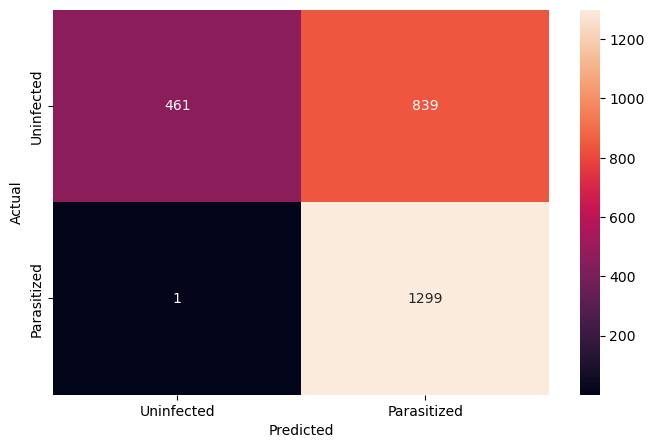

In [79]:
pred = model_hsv_image_gen.predict(test_gfx)
pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)
# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Observations: 
The HSV model seem to perform worse with augmentated data, compared with any other model.

### Model Comparisions: 
let plot the test accuracy of all the models.

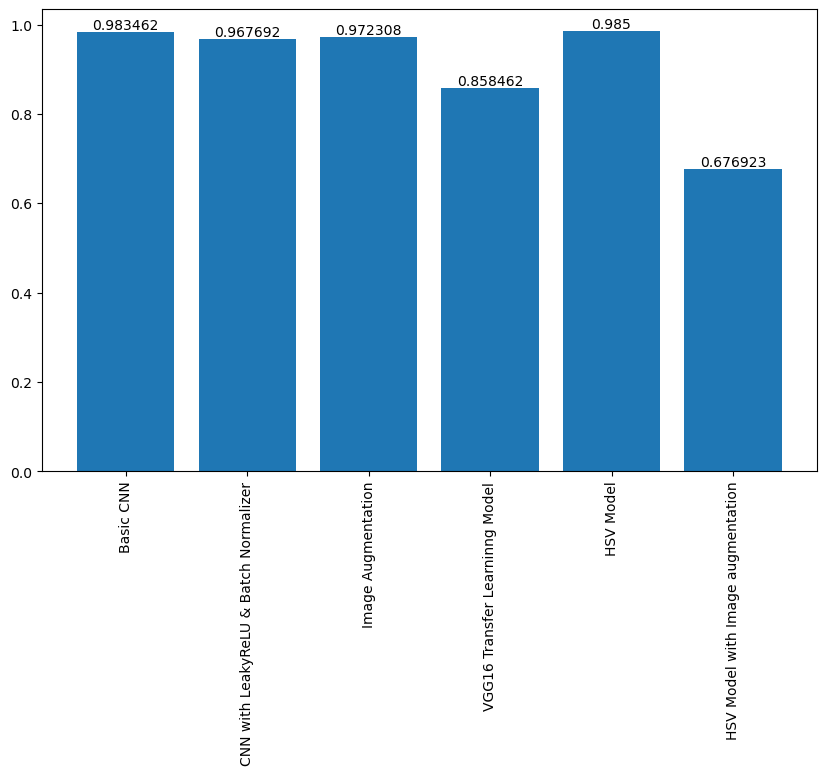

In [82]:
plt.figure(figsize=(10, 6))
bars = plt.bar(x = results.keys(), height = results.values())
plt.xticks(rotation = 90)
plt.bar_label(bars)
plt.show()

#### Observations and Conclusions drawn from the above Figure:
* The Model seems to have similar accuracy alevels across the different models, except fot the transfer learning model and i8mage augmented HSV model.
* The best model can be determined by looking at the accuracy of the model. specifically, the image augmented model due to its ability to handle varaious noises in the images and its accuracy is comparable to the model with no noise images.

#### Saving the Model

In [81]:
model_augmented.save('Malaria_model.h5')

#### Future actions:
* Review of the cell images that seemed to be wrongly predicted. making sure they are not labeled wrong, using experts help.
* Collect more cell images datasets samples with varying parasite markers and update these models using the updated dataset.
* In Conclusion, The Model trained would be able to predict whether a cell is infected with malaria parasite with 97% accuracy . Since the model is trained on some noise it will do a great job even if the image is not perfect.